# L08: Monte Carlo methods

**Sources and additional reading:**
- Herrmann, [Introduction to computational physics](https://ethz.ch/content/dam/ethz/special-interest/baug/ifb/ifb-dam/homepage-IfB/Education/bsc_courses/bsc-intro-comphys/documents/CompPhysScript-2017.pdf)
- Ivezić, chapters 3.7 and 5.8
- MacKay, [Information Theory, inference, and learning algorithms](http://www.inference.org.uk/mackay/itila/book.html)

## Introduction

In the last lecture we have seen that once we have derived the posterior for a given set of model parameters, we can derive the expectation value of any function $\phi$ of the parameters $\boldsymbol{\theta}$ by integrating over the posterior as $$\langle \phi(\boldsymbol{\theta}) \rangle = \int\mathrm{d}\boldsymbol{\theta}\; \phi(\boldsymbol{\theta}) P(\boldsymbol{\theta}|\boldsymbol{x}, M).$$ 

The parameter set $\boldsymbol{\theta}$ is often high-dimensional, which makes solving these integrals computationally very expensive, if not impossible. So the question is - how do we compute these integrals in practice and thus learn about the posterior distribution of a given set of model parameters? 

## Monte Carlo methods

Monte Carlo (MC) methods are techniques that make use of random numbers. Amongst others, these methods can be used for the following tasks:

**Application 1:** MC methods can be used to generate samples $\{\boldsymbol{\theta}_i\}_{i=1}^n$ drawn from a probability distribution $P(\boldsymbol{\theta})$.

**Application 2:** MC methods can also be used to estimate expectation values of functions under a given probability distribution, i.e. $$\Phi = \langle \phi(\boldsymbol{\theta}) \rangle = \int\mathrm{d}\boldsymbol{\theta}'\; \phi(\boldsymbol{\theta}') P(\boldsymbol{\theta}'),$$ which is exactly what we need as discussed above.

In practice these two applications are closely linked as if we can generate a sample $\{\boldsymbol{\theta}_i\}_{i=1}^n$ from a pdf $P(\boldsymbol{\theta})$, then we can estimate the expectation value of a given function $\phi$ as $$\hat{\Phi} = \frac{1}{n}\sum_{i=1}^n\phi(\boldsymbol{\theta}_i).$$ This is a *Monte Carlo* integral estimate of $\Phi$. We can check that this is indeed unbiased by computing $$\langle \hat{\Phi} \rangle = \left \langle \frac{1}{n}\sum_{i=1}^n\phi(\boldsymbol{\theta}_i)\right\rangle =\frac{1}{n}\sum_{i=1}^n\langle\phi(\boldsymbol{\theta}_i)\rangle = \frac{1}{n}\sum_{i=1}^n\int\mathrm{d}\boldsymbol{\theta}\; \phi(\boldsymbol{\theta}) P(\boldsymbol{\theta})=\int\mathrm{d}\boldsymbol{\theta}\; \phi(\boldsymbol{\theta}) P(\boldsymbol{\theta}).$$ One of the advantages of MC integration compared to traditional integration methods is that the variance of this estimator scales as $\propto \frac{1}{n}$ (as it is a mean of n random variables) but it does not (or only weakly) depend on the dimensionality of the parameter space. As a rule of thumb, this makes it more efficient than traditional integration methods for dimensions $d>4$ (this particular value is for trapezoidal integration methods). 

The above considerations show that essentially the main issue we need to tackle with Monte Carlo methods is to generate samples from a given probability distribution. But this is hard for many reasons.

1. We can often only generate samples from $P^*(\boldsymbol{\theta})=P(\boldsymbol{\theta})/Z$, where $Z$ denotes a normalizing constant.
2. Even if we can generate samples from $P(\boldsymbol{\theta})$, this is still difficult, as we would preferentially like points where $P(\boldsymbol{\theta})$ is high. But how do we know where this is before having sampled $P(\boldsymbol{\theta})$ everywhere?

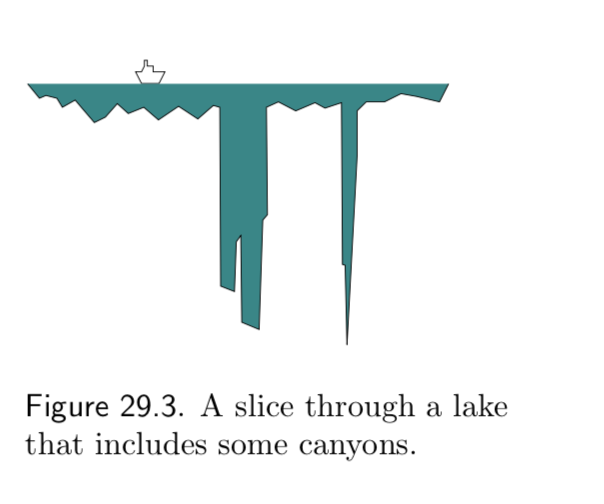

## Generating samples from pdfs

### Rejection sampling

Let us assume for simplicity that we have a one-dimensional pdf $P(\boldsymbol{\theta})$ from which we would like to generate a random sample $\{\boldsymbol{\theta}_i\}_{i=1}^n$. The rejection method works as follows:

1. Find a proposal distribution $Q(\boldsymbol{\theta})$ from which we can easily draw samples. In the simplest case, this is the uniform distribution, but if we know something about $P(\boldsymbol{\theta})$, we could also choose $Q(\boldsymbol{\theta})$ similar to $P(\boldsymbol{\theta})$. 
2. Determine a constant $c$ such that $c \geq \frac{P(\boldsymbol{\theta})}{Q(\boldsymbol{\theta})}$ for all $\boldsymbol{\theta}$.
2. Generate a random sample $\boldsymbol{\theta}_{i}$ from $Q(\boldsymbol{\theta})$.
3. Generate a uniform sample $u_i$ in $[0, 1]$.
4. If $u_i\leq \frac{P(\boldsymbol{\theta}_i)}{c Q(\boldsymbol{\theta}_i)}$, accept the point, otherwise reject it.
5. Repeat until you have generated $n$ samples.

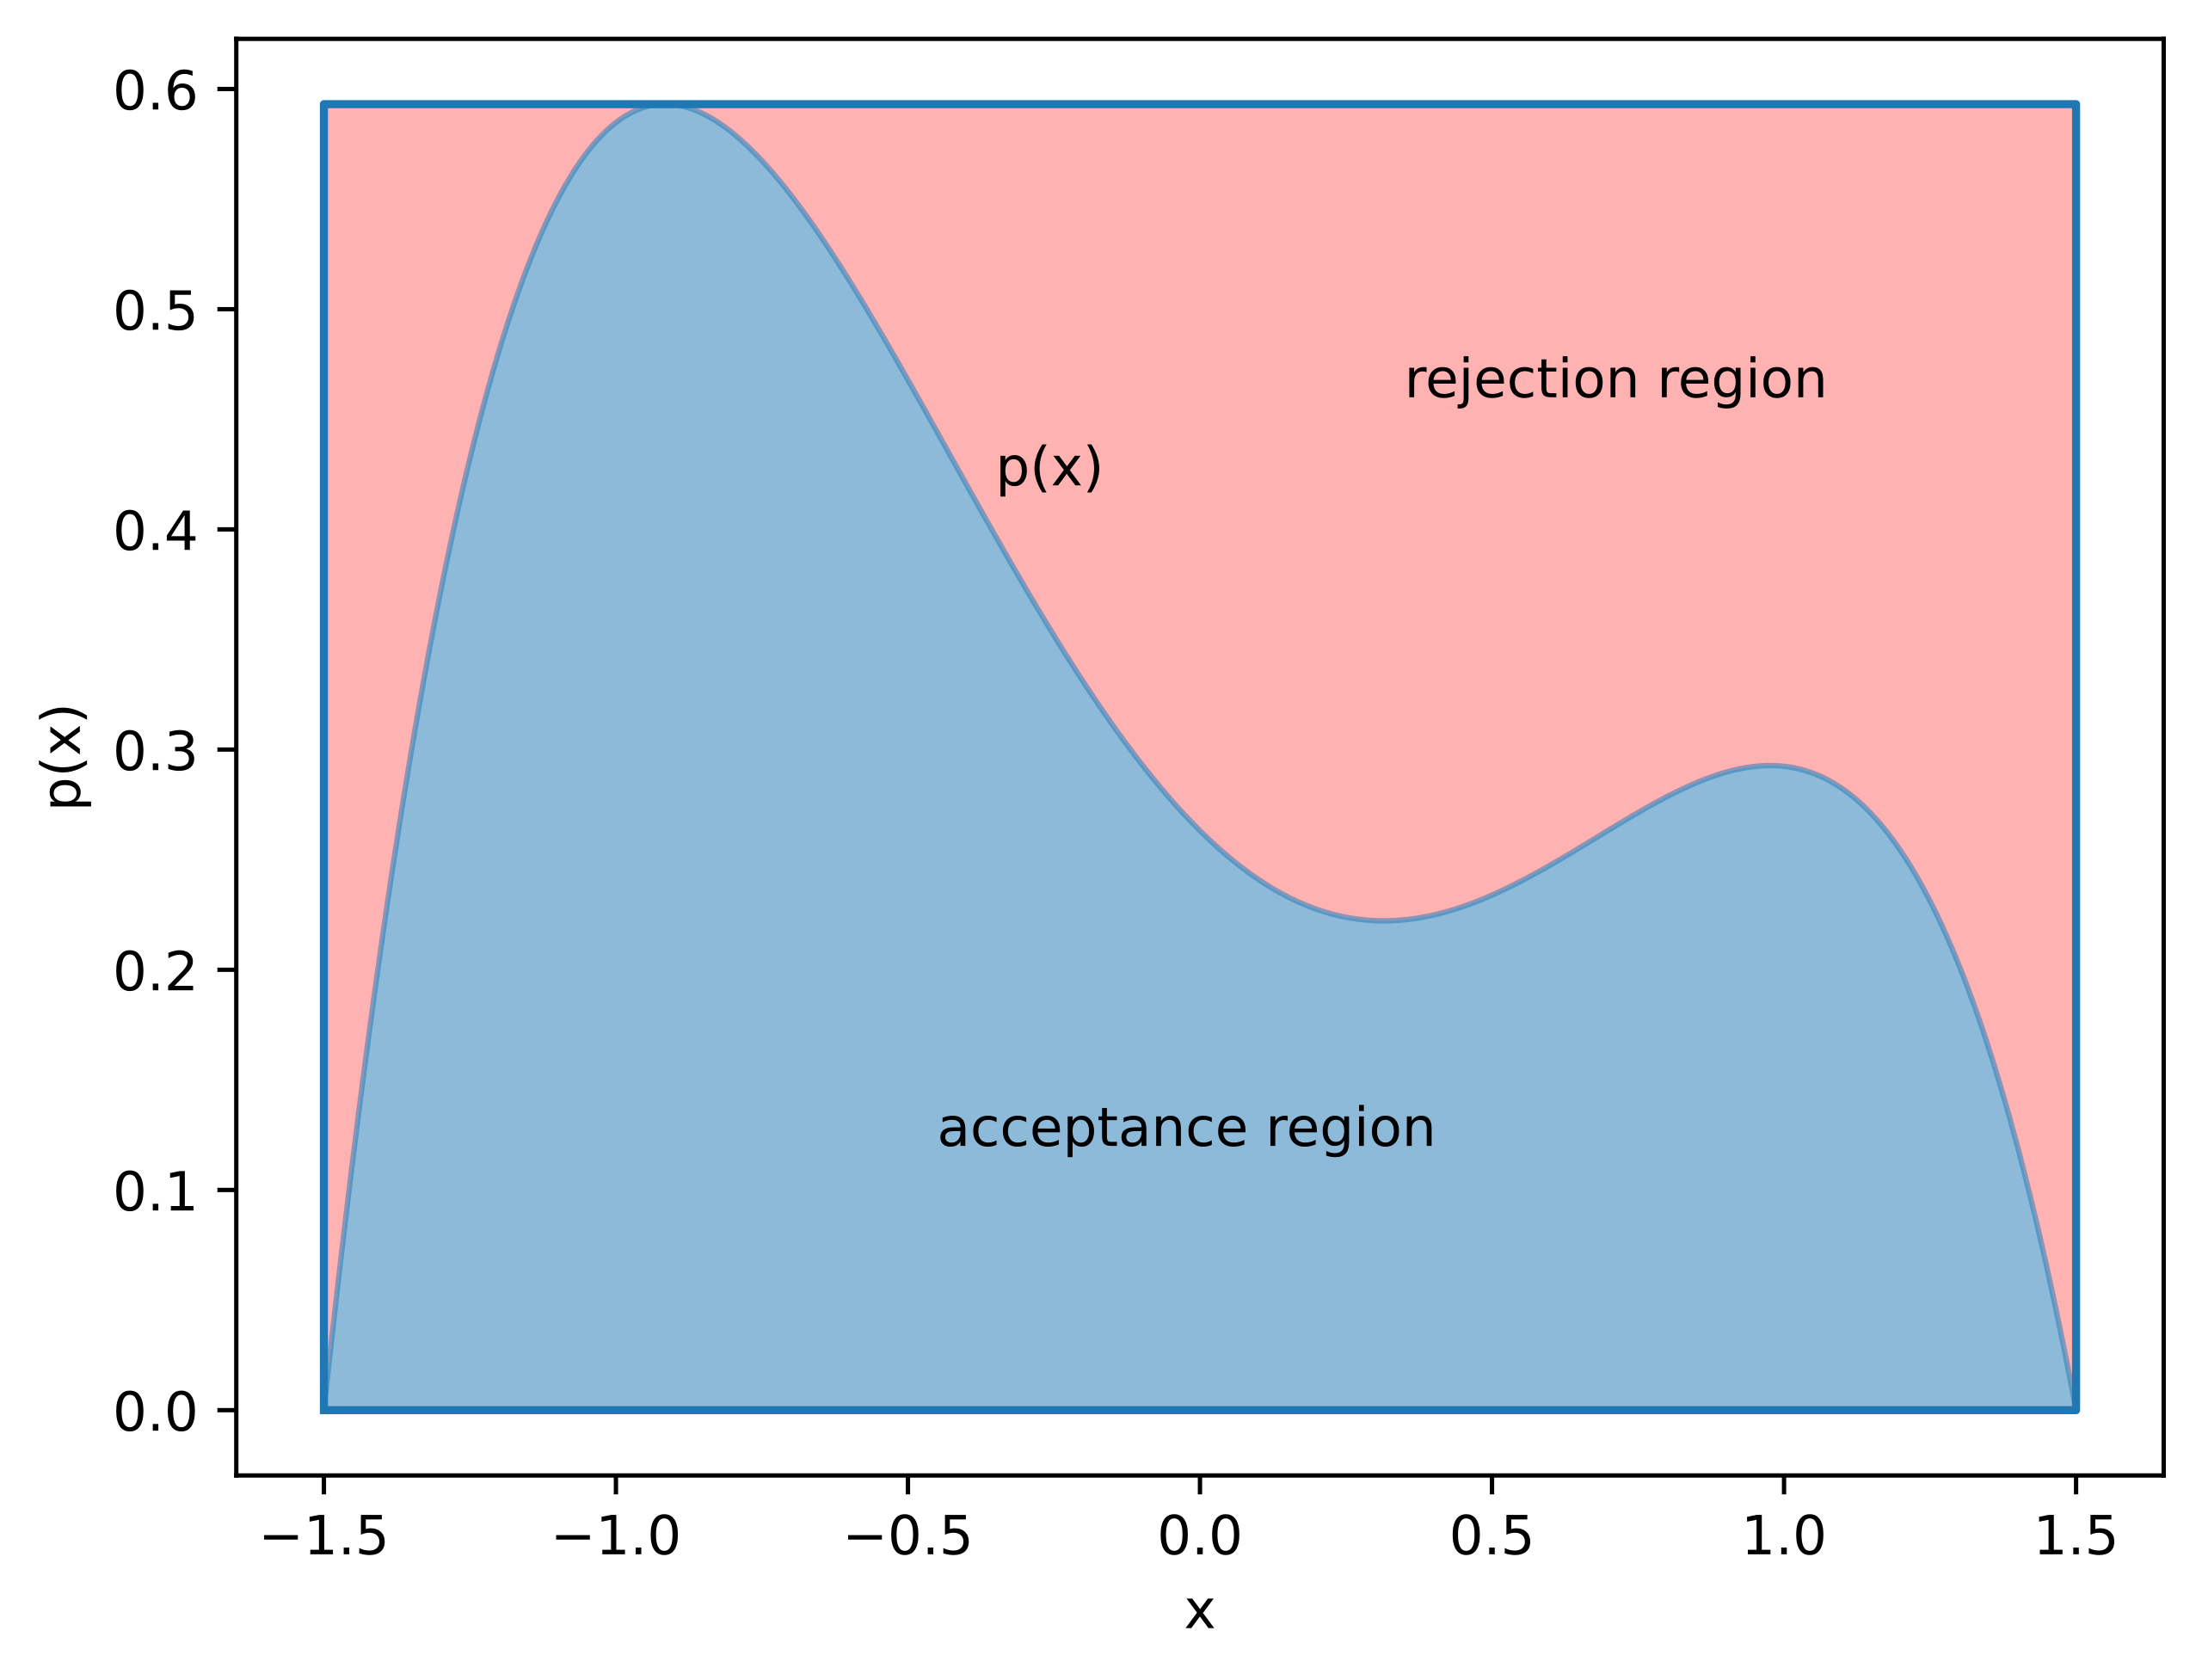

Intuitively, this method accepts a point based on how high $P(\boldsymbol{\theta}_i)$ is compared to $cQ(\boldsymbol{\theta}_i)$, i.e. the probability to keep a point $\boldsymbol{\theta}_{i}$ with large $P(\boldsymbol{\theta}_i)$ is larger than that for points with low $P(\boldsymbol{\theta}_i)$. The method is simple, it does not require $P(\boldsymbol{\theta})$ to be normalized, and it can be applied to arbitrary pdfs as well as in multi-dimensional cases. A drawback is however, that not all generated points are accepted, so it can take a while to generate a sample. 

**Example**

Let us look at an example of accept-reject sampling in `python`.

Let's first create a slightly crazy distribution $P(\boldsymbol{\theta})$ that we would like to sample from, that's how it looks like:

Text(0, 0.5, '$P(\\theta)$')

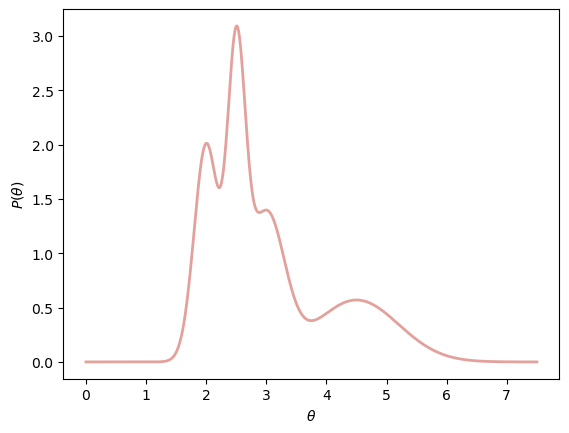

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

mus = np.array([2, 2.5, 3, 4.5])
sigmas = np.array([0.2, 0.15, 0.3, 0.7])

def pdf(x):

    pdf_temp = 0
    for i in range(mus.shape[0]):
        pdf_temp += scipy.stats.norm.pdf(x, loc=mus[i], scale=sigmas[i])
        
    return pdf_temp

x = np.linspace(0, 7.5, 1000)
pdf_test = pdf(x)

plt.plot(x, pdf_test, color='#e3a19c', linewidth=2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta)$')
# plt.legend(frameon=False)

Let's define a uniform box around it as our proposal distribution $Q(\boldsymbol{\theta})$:

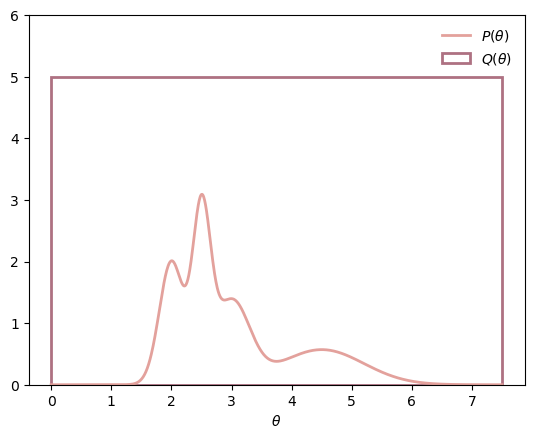

In [8]:
xmin = 0
xmax = 7.5
pmax = 5

plt.plot(x, pdf_test, color='#e3a19c', linewidth=2, label=r'$P(\theta)$')
plt.axvspan(0, 7.5, ymin=0, ymax=1./1.2, fill=False, color='#AE7182', linewidth=2, label=r'$Q(\theta)$')
plt.xlabel(r'$\theta$')
plt.ylim(0, 1.2*pmax)
plt.legend(frameon=False)

Now let's sample this distribution using accept-reject:

Fraction of accepted points = 0.10736.


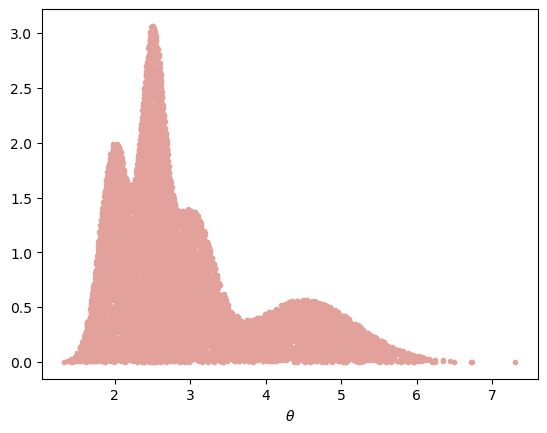

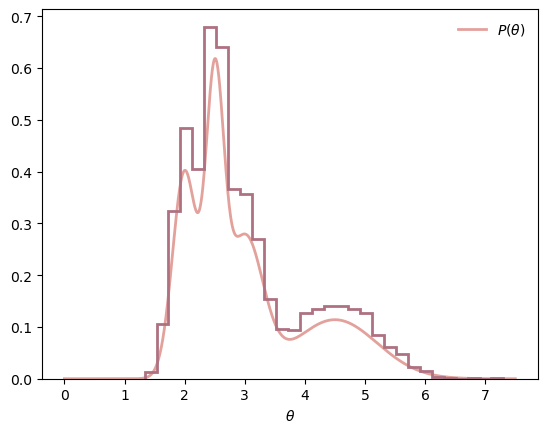

In [9]:
npoints = 100000

xs = np.random.uniform(xmin,xmax,npoints)  #get uniform temporary x values
ys = np.random.uniform(0,pmax,npoints)  # get uniform random y values

# Keep only the points below the pdf we want to sample
mask = ys < pdf(xs)

print('Fraction of accepted points = {}.'.format(np.sum(mask)/npoints))

# Plot the accepted points
plt.figure()
plt.scatter(xs[mask], ys[mask], marker='.', color='#e3a19c')
plt.xlabel(r'$\theta$')

# Plot the normalized histogram
plt.figure()
plt.plot(x, pdf_test/5., color='#e3a19c', linewidth=2, label=r'$P(\theta)$')
plt.hist(xs[mask], histtype='step', color='#AE7182', linewidth=2, bins=30, density=True)
plt.xlabel(r'$\theta$')
plt.legend(frameon=False)

Thus we see that depending on the chosen uniform box boundary, the algorithm becomes extremely inefficient. And this is only in one dimension...

### Inverse transform sampling

The method of inverse transform sampling can only be applied for one-dimensional distributions (or to mutlidimensional distribution that are mutually independent), but it is very efficient, as it gives us a way to keep all proposed points. 

Let us again assume that we have a normalized (!), one-dimensional pdf $P(\boldsymbol{\theta})$ from which we would like to generate a random sample $\{\boldsymbol{\theta}_i\}_{i=1}^n$. In addition, we denote the cdf of $P$ by $F(\boldsymbol{\theta}_0) = \mathrm{Pr}(\boldsymbol{\theta} \leq \boldsymbol{\theta}_0)$. The inverse transform sampling method is based on the fact that the cdf of an arbitrary pdf is uniformly distributed over $[0, 1]$. With this we can define the following procedure to generate a random sample from $P(\boldsymbol{\theta})$:

1. Generate a random sample $u_i$ uniformly distributed over $[0, 1]$.
2. Define $\boldsymbol{\theta}_i=F^{-1}(u_i)$. With this transformation, $\boldsymbol{\theta}_i$ will be distributed according to $P(\boldsymbol{\theta})$.

For a very nice `python` example of inverse transform sampling, please see [here](https://cosmiccoding.com.au/tutorials/inversion_sampling/).

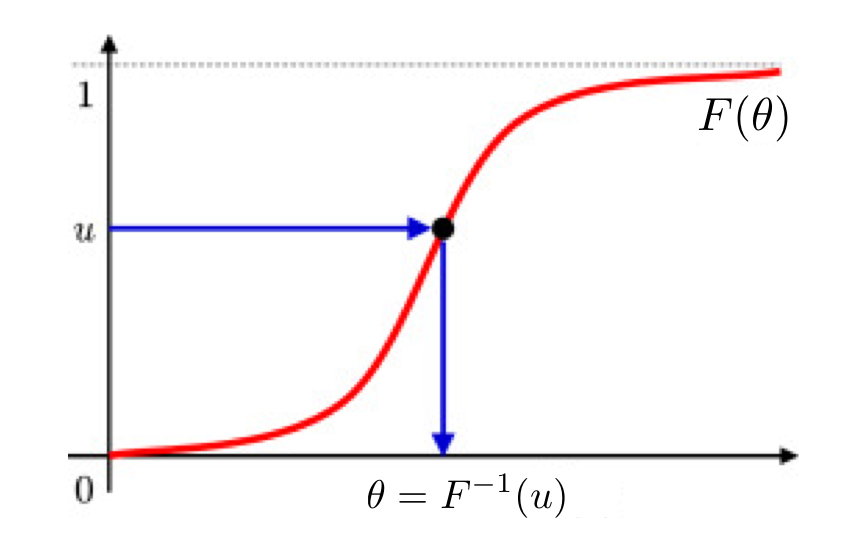

## Markov Processes/Markov Chains

Before we look at the theory behind Markov Processes/Markov Chains, let us look at an example. Note that Markov Processes/Markov Chains are often used interchangeably in the literature, and we will follow this approach here also. If there is a distinction, people usually call discrete processes Markov Chain and continuous processes Markov Process.

### Example

Let us assume that there are only two stores in Germany: Lidl and Aldi. Customers choose their store at random each week, but their choice for next week depends on where they shopped this week (and not on anything before).

We assume the following: A Lidl customer this week, has an $80\%$ probability of shopping there again next week, while there is a $20\%$ probability for the customer to switch to Aldi. For an Aldi customer this week on the other hand, there is a $70\%$ probability to stay with Aldi, and a $30\%$ probability to switch to Lidl. The situation is illustrated in the figure below.

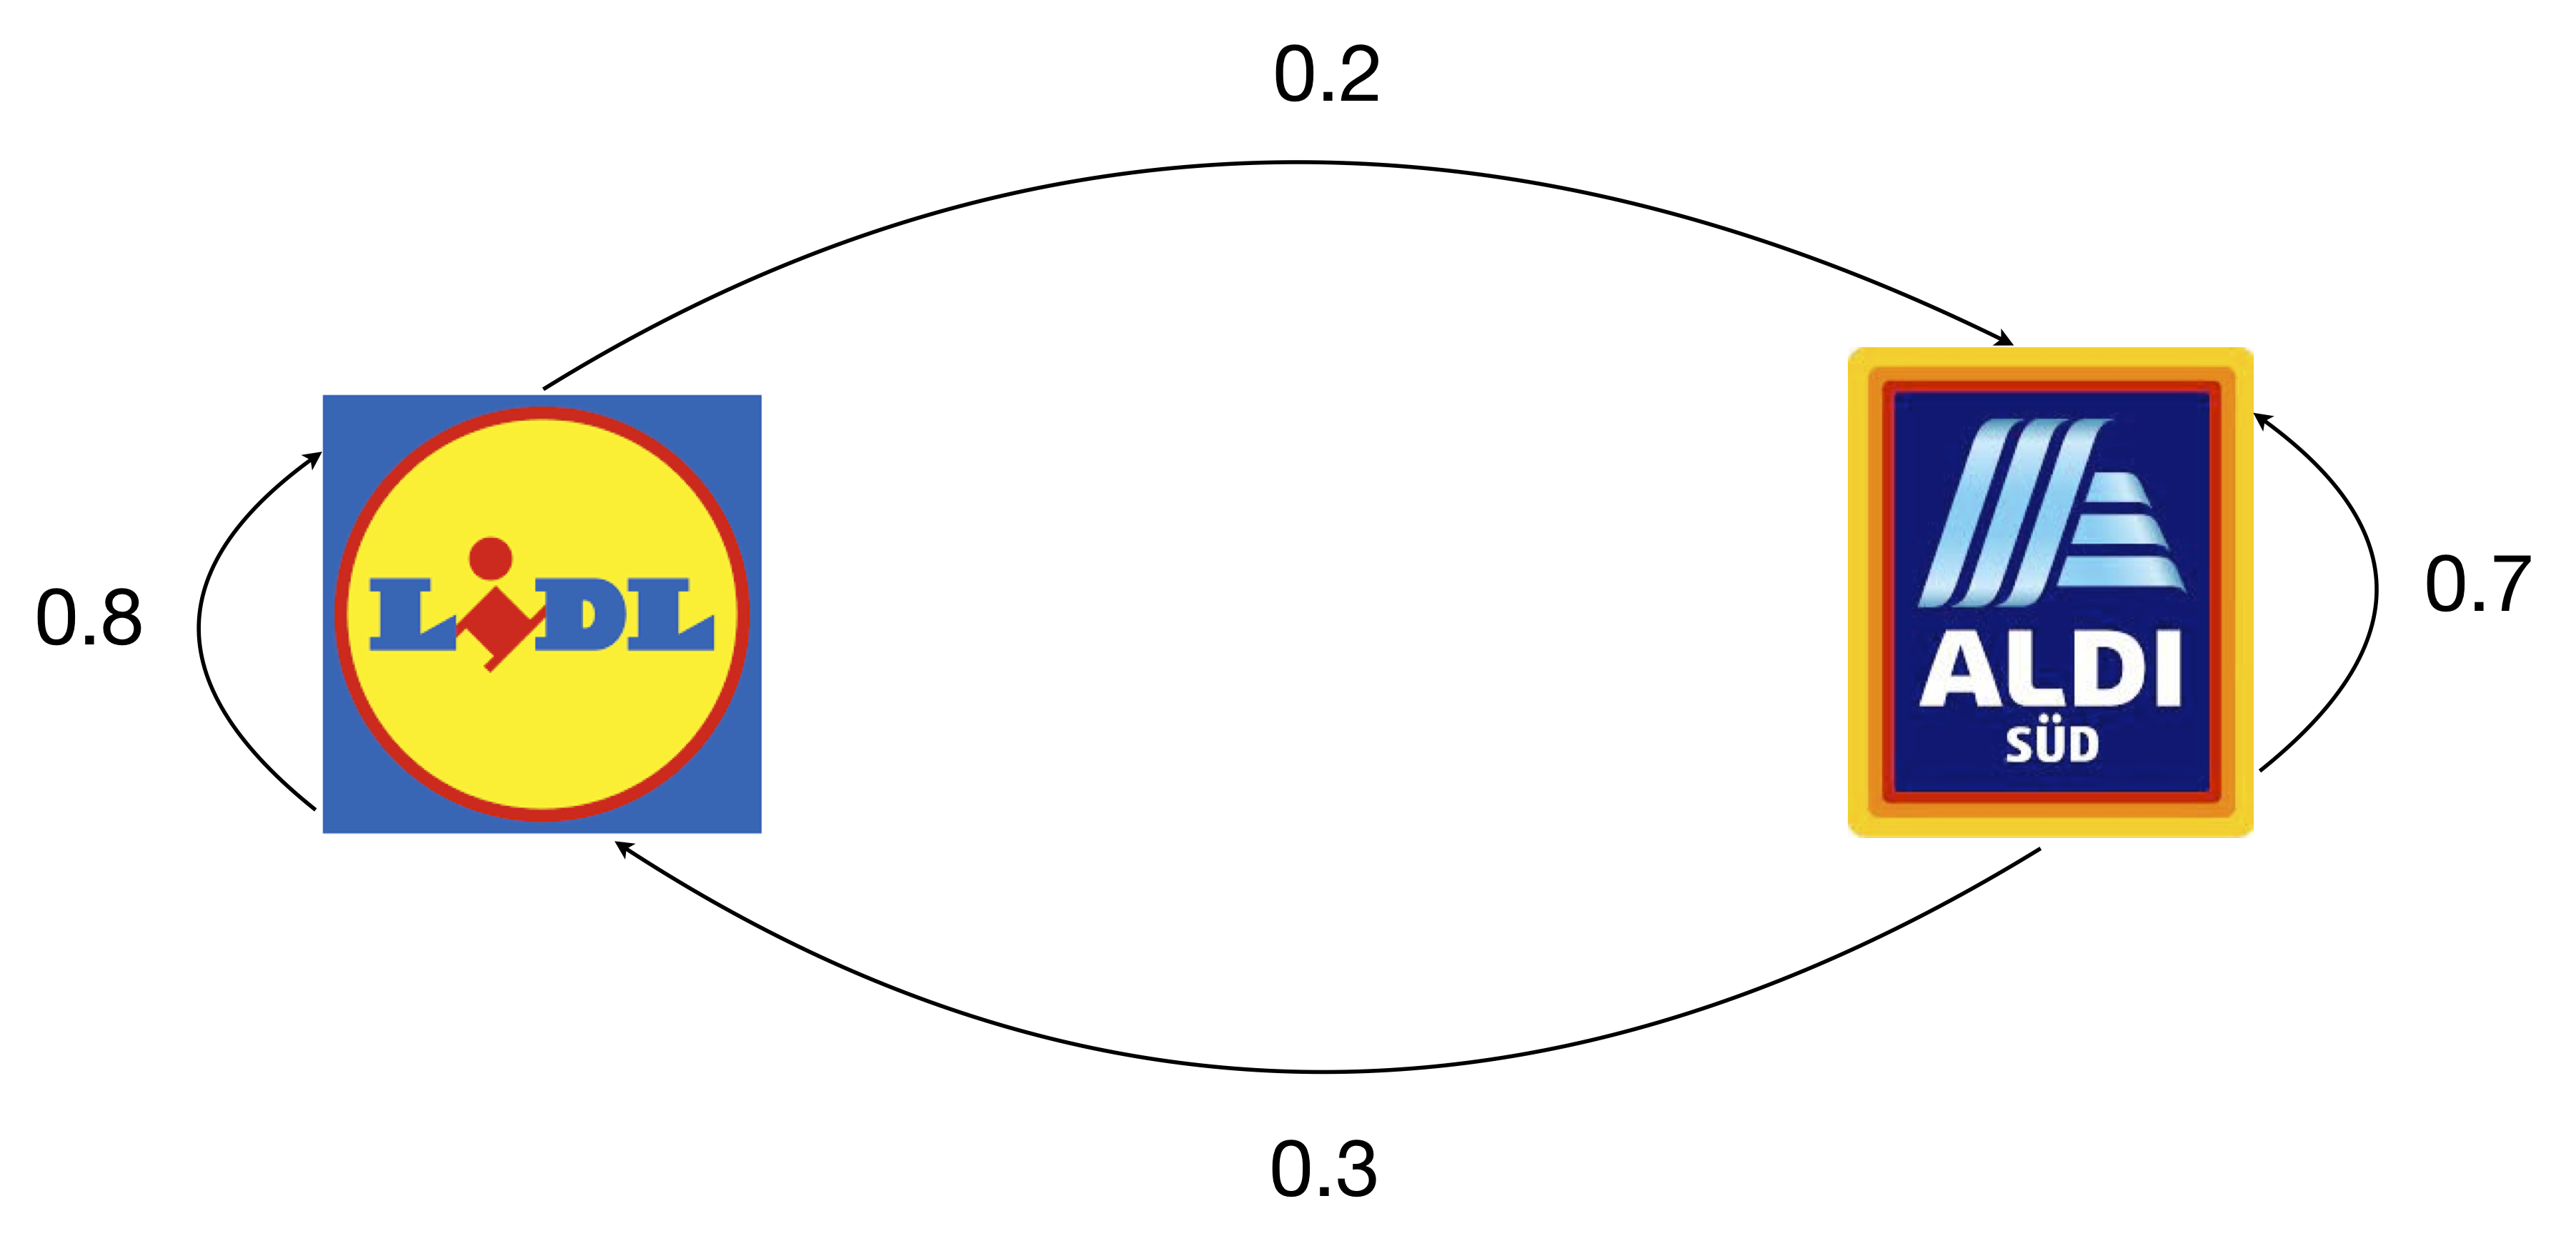

Let $X_0$ denote the current week, $X_1$ the next week, and $L$, $A$ Lidl and Aldi respectively. Then we can express the transition probability as a matrix as $$T = \begin{pmatrix}
P(X_1=L|X_0=L) & P(X_1=A|X_0=L)  \\
P(X_1=L|X_0=A) & P(X_1=A|X_0=A) 
\end{pmatrix} = \begin{pmatrix}
0.8 & 0.2  \\
0.3 & 0.7
\end{pmatrix}.$$ Suppose that at $X_0$ we have that $40\%$ of customers shop at Lidl and $60\%$ at Aldi. How is the market share going to look like in week $X_1$?

We have that $$P(X_1=L)=P(X_1=L|X_0=L)P(X_0=L)+P(X_1=L|X_0=A)P(X_0=A)=0.5$$ and $$P(X_1=A)=P(X_1=A|X_0=A)P(X_0=A)+P(X_1=A|X_0=L)P(X_0=L)=0.5.$$ So after a week, the market share of Aldi has gone down to $50\%$. We can write this as $$p_1=p_0T,$$ where $p_0=(P(X_0=L), P(X_0=A))=(0.4, 0.6)$.

Continuing this pattern, this means that after $m$ weeks we have $$p_m=p_0T^m.$$ Thus after two weeks we have $p_2=(0.55, 0.45)$.

The question now is: Is there a steady state? And if yes, what is it? 

For a steady state $\pi$ we need $$\pi=\pi T,$$ i.e. we need to solve the following equations $$\pi_L=0.8\pi_L+0.3\pi_A,$$ $$\pi_A=0.7\pi_A+0.2\pi_L,$$ which gives $\pi_L=1.5\pi_A$, and thus using the normalization property we have $\pi_L=0.6$ and $\pi_A=0.4$.

Another way to investigate the long-term behavior of the process and thus an eventual steady-state is to consider the situation for large values of $m$. If the steady-state exists and the Markov Chain converges to it (we will see below what is required for this to occur), we have $$\pi=p_0\lim_{m\to \infty}T^m,$$ i.e. in this case the Markov chain will reach its steady-state after a long enough time. Since this statement holds for any initial state $p_0$, we thus get $$\pi_j=\lim_{m\to \infty}(T^m)_{ij}, \mathrm{for}\; \mathrm{all} \;i,$$ provided the steady-state exists. Therefore, the Markov chain converges to the steady-state distribution as $m\to \infty$ independent of its starting point. In addition, in this limit $\lim_{m\to \infty}(T^m)_{ij}$ will have all rows equal to the stady state distribution $\pi$.

Let us simulate this example in `python`:

In [3]:
# Transition matrix
T = np.array([[0.8, 0.2], [0.3, 0.7]])

# Initial state: 40% of customers at Lidl, 60% at Aldi
p0 = np.array([0.4, 0.6])

p1 = np.dot(p0, T)
print('After one step: p = {}.'.format(p1))

p2 = np.dot(p1, T)
print('After two steps: p = {}.'.format(p2))

# Let's look at the long-term behavior
p100 = np.dot(p0, np.linalg.matrix_power(T, 100))
print('After 100 steps: p = {}.'.format(p100))

p200 = np.dot(p0, np.linalg.matrix_power(T, 200))
print('After 200 steps: p = {}.'.format(p200))

print('')
print('')
print('Convergence of transition matrix powers:')

print('After 4 steps: T = {}.'.format(np.linalg.matrix_power(T, 4)))

print('')
print('After 10 steps: T = {}.'.format(np.linalg.matrix_power(T, 10)))
print('')
print('After 100 steps: T = {}.'.format(np.linalg.matrix_power(T, 100)))

After one step: p = [0.5 0.5].
After two steps: p = [0.55 0.45].
After 100 steps: p = [0.6 0.4].
After 200 steps: p = [0.6 0.4].


Convergence of transition matrix powers:
After 4 steps: T = [[0.625  0.375 ]
 [0.5625 0.4375]].

After 10 steps: T = [[0.60039063 0.39960938]
 [0.59941406 0.40058594]].

After 100 steps: T = [[0.6 0.4]
 [0.6 0.4]].


### Example: Convergence failures

Let us now assume that the experience of shopping at Aldi or Lidl is so terrible that customers after one week are completely convinced they need to switch, i.e. we have $$T = \begin{pmatrix}
P(X_1=L|X_0=L) & P(X_1=A|X_0=L)  \\
P(X_1=L|X_0=A) & P(X_1=A|X_0=A) 
\end{pmatrix} = \begin{pmatrix}
0 & 1  \\
1 & 0
\end{pmatrix}.$$ Let us simulate this example.

In [6]:
import numpy as np

# Transition matrix
T = np.array([[0, 1], [1, 0]])

# Initial state: 40% of customers at Lidl, 60% at Aldi
p0 = np.array([0.4, 0.6])

p1 = np.dot(p0, T)
print('After one step: p = {}.'.format(p1))

p2 = np.dot(p1, T)
print('After two steps: p = {}.'.format(p2))

# Let's look at the long-term behavior
p100 = np.dot(p0, np.linalg.matrix_power(T, 100))
print('After 100 steps: p = {}.'.format(p100))

p101 = np.dot(p0, np.linalg.matrix_power(T, 101))
print('After 101 steps: p = {}.'.format(p101))

print('')
print('')
print('Convergence of transition matrix powers:')

print('After 4 steps: T = {}.'.format(np.linalg.matrix_power(T, 4)))

print('')
print('After 10 steps: T = {}.'.format(np.linalg.matrix_power(T, 10)))
print('')
print('After 100 steps: T = {}.'.format(np.linalg.matrix_power(T, 100)))
print('')
print('After 101 steps: T = {}.'.format(np.linalg.matrix_power(T, 101)))

After one step: p = [0.6 0.4].
After two steps: p = [0.4 0.6].
After 100 steps: p = [0.4 0.6].
After 101 steps: p = [0.6 0.4].


Convergence of transition matrix powers:
After 4 steps: T = [[1 0]
 [0 1]].

After 10 steps: T = [[1 0]
 [0 1]].

After 100 steps: T = [[1 0]
 [0 1]].

After 101 steps: T = [[0 1]
 [1 0]].


So we see that in this case, the steady-state will never be reached but the process will oscillate between the two possible states (in other words, it will never forget its initial state).

Aside: This is a special case as the steady-state actually does exist but it will never be reached by the Markov Chain.

### Theoretical description

A Markov Chain is a stochastic process that results in a sequence of random variables. The key property of Markov Chains is that they allow us to consider situations where the future evolution of the process of interest depends on where it is at present, but not on how it got there. This is different from the iid random variables that we have encountered so far as for independent trial processes the possible outcomes of each trial of the experiment are the same and occur with the same probability. With Markov chain models we can generalize this to the extent that we allow the future to depend on the current state.

This property can be formalized as follows. Let the sequence of random variables $x_1, ..., x_n$ denote a Markov Chain. The probability of each successive step then satisifes $$P(X_{n+1}=x_{n+1}|X_1=x_1, ..., X_n=x_n)=P(X_{n+1}=x_{n+1}|X_n=x_n),$$ i.e. the next step only depends on the last step. Or in other words, given the current state, the past and the future are conditionally independent.

A Markov Chain can be characterized by the so-called transition probability $T(X_i\to X_{i+1})$. Often the transition probability is subdivided into a proposal probability $Q(X_i\to X_{i+1})$ and an acceptance probablity $A(X_i\to X_{i+1})$ as $$T(X_i\to X_{i+1})=Q(X_i\to X_{i+1})A(X_i\to X_{i+1}).$$ Essentially the proposal probability quantifies the probability to propose a new state $X_{i+1}$ starting from $X_{i}$, while the acceptance probability gives the chances of actually accepting the step. The full Markov probability of each state is then characterized by the product of these two.

As seen in the example, one important question to ask is if a given Markov Chain will reach an equilibrium state. In general, this is only the case for a subset of Markov Chains. These are called *ergodic*. An *ergodic* Markov Chain is defined to be both *irreducible* and *aperiodic*. 

- *irreducible*: A Markov Chain is called irreducible if all states can be reached from any other state in a finite number of moves.
- *aperiodic*: A state in a Markov Chain is called periodic if the probability of recurrence is non-zero only for some integer $n$ number of steps. The state is called aperiodic otherwise. A Markov Chain whose states are all aperiodic is called aperiodic.

One can show that these two conditions together imply that there exists an integer $m$ such that all transition probabilities are positive for all $n\geq m$. In this case, the Markov Chain has a unique equilibrium distribution and it is guaranteed to reach it for $n\to\infty$, independent of the initial conditions.

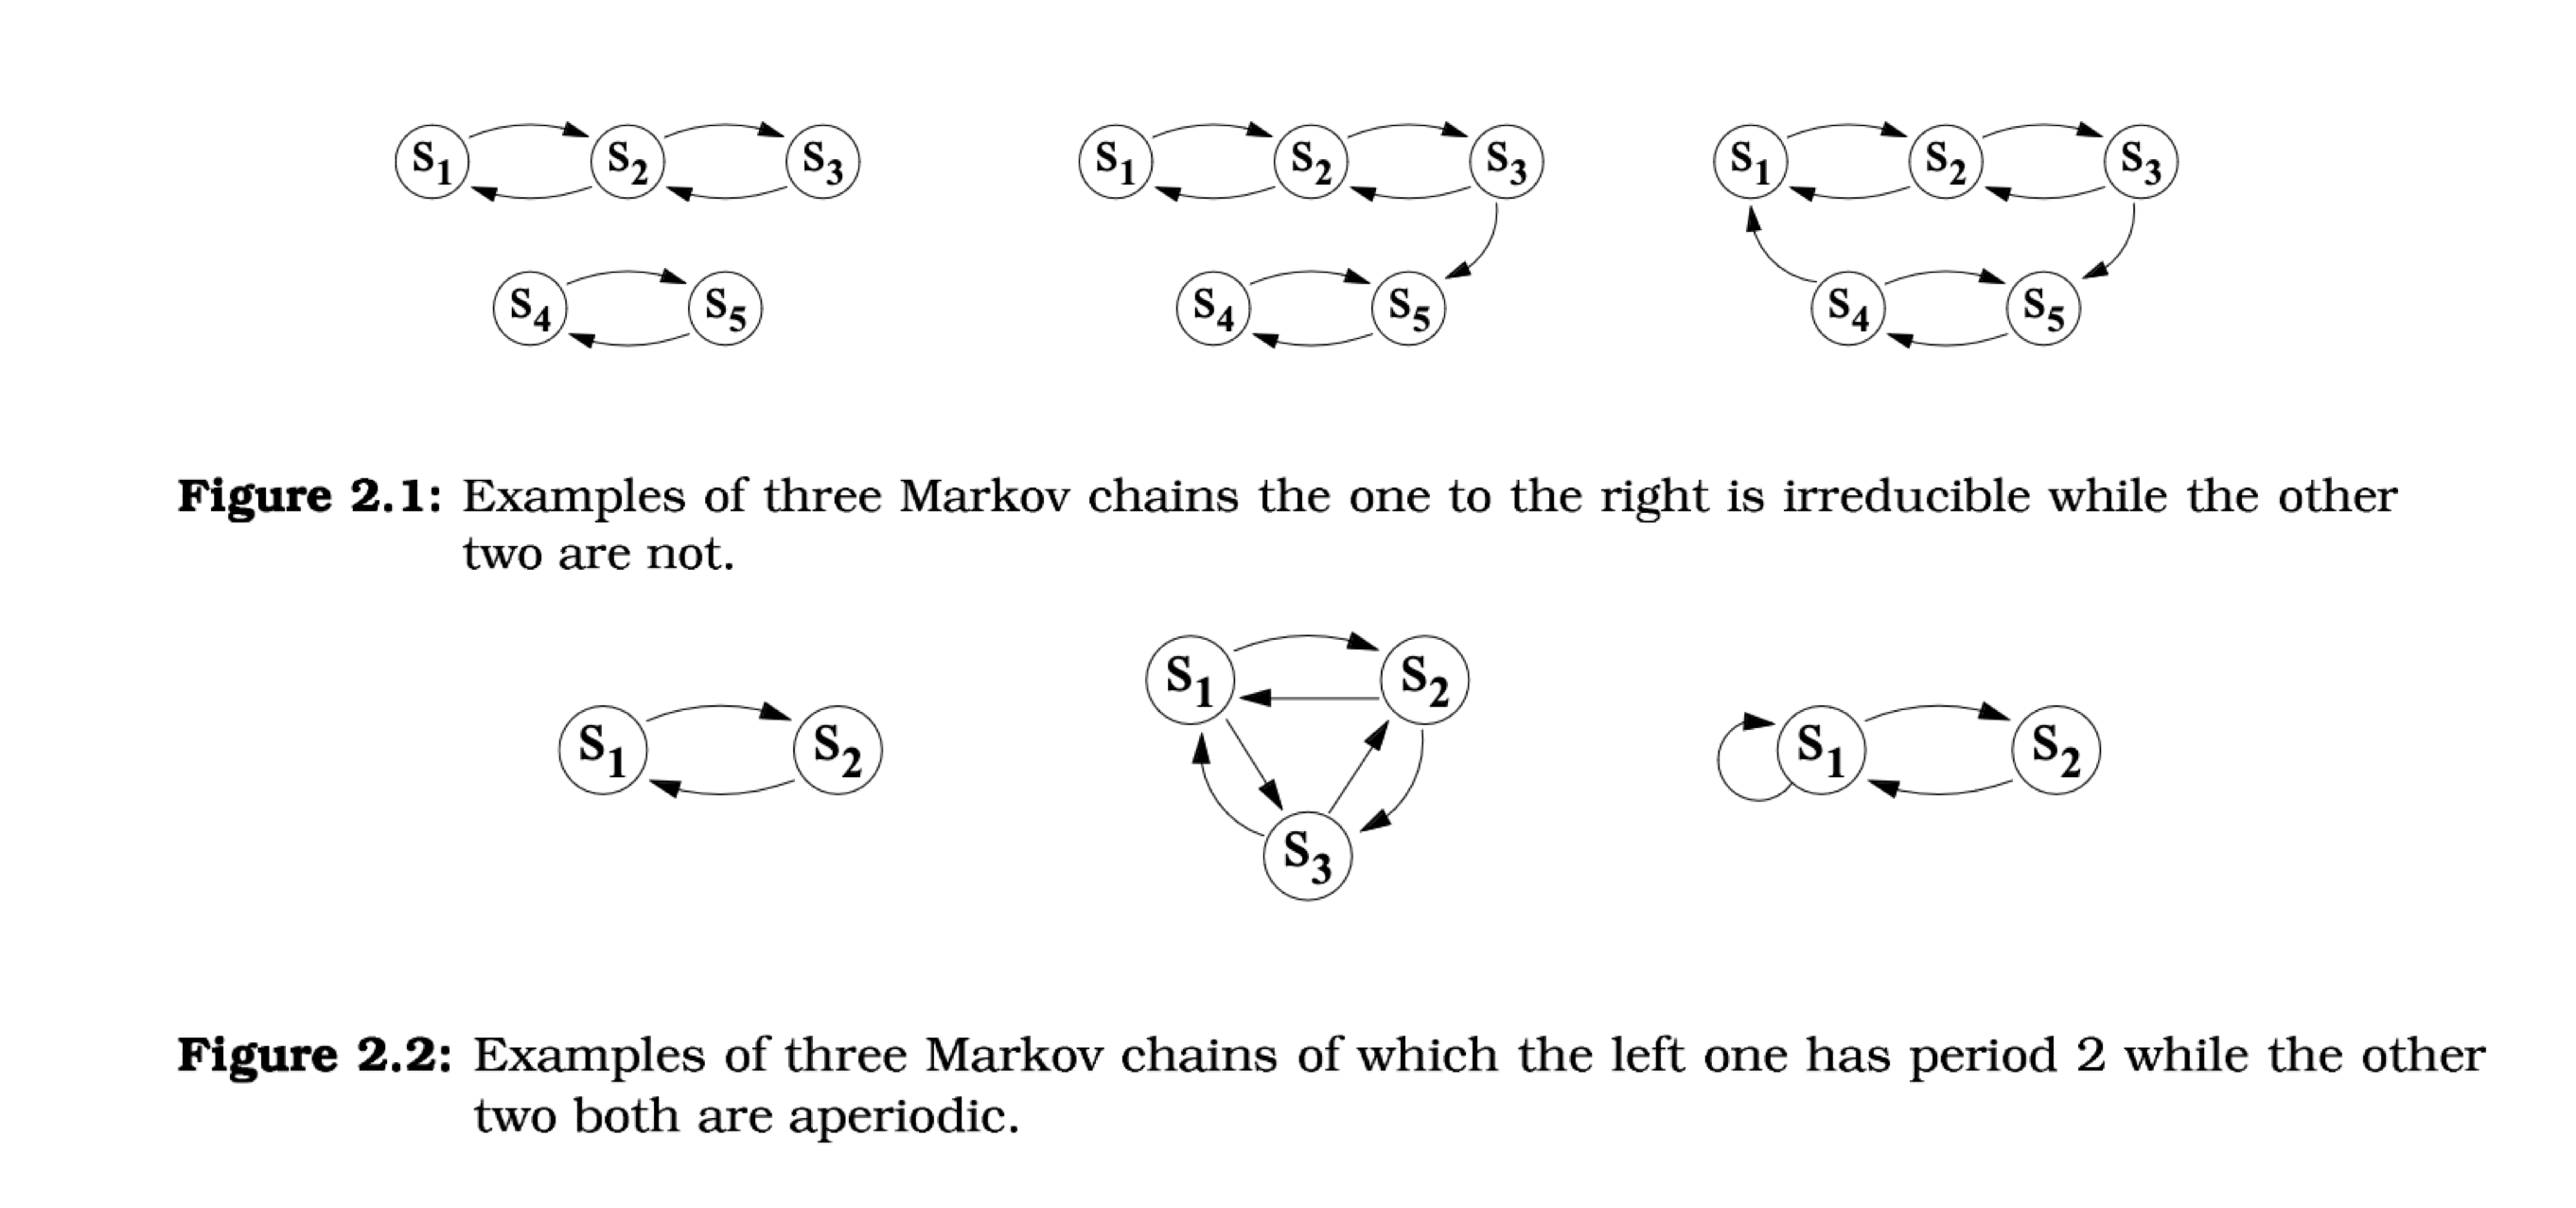

Let us now derive the steady-state distribution for a general Markov Chain. In general, we are interested in the probability of state $X_{j}$ as a function of time, i.e. $P(X_{j}, t)$. Given the properties of the Markov Chain this probability is changed by two processes:

- A configuration $X_{j}$ is produced by coming from $X_{i}$ (this will contribute positively).
- A configuration $X_{j}$ is destroyed by going to some other configuration (this will decrease the probability).

Thus we have $$\frac{\mathrm{d}P(X_{j}, t)}{\mathrm{d}t} = \sum_i P(X_i)T(X_i\to X_j) - \sum_i P(X_j)T(X_j\to X_i).$$ Of particular interest are stationary states of the Markov Chain, i.e. states with $\frac{\mathrm{d}P(X_{j}, t)}{\mathrm{d}t}=0$. From above this implies that $$\sum_i P(X_i)T(X_i\to X_j) =\sum_i P(X_j)T(X_j\to X_i) = P(X_j).$$

A sufficient, but not necessary condition for stationarity is the condition of *detailed balance*, i.e. $$P(X_i)T(X_i\to X_j) = P(X_j)T(X_j\to X_i).$$ The crucial thing is that if we construct an *ergodic* Markov Chain that obeys the detailed balance condition, then $P(X)$ is its stationary distribution and it is guaranteed to converge to it as $n\to\infty$.

## Monte Carlo Markov Chains

Monte Carlo Markov Chains (MCMC) are the application of Markov Chains to sample from probability distributions. In other words instead of the sampling methods we have described before, MCMCs generate a Markov Chain with stationary distribution $P(X)$ to generate a sample from this distribution. The main idea here is that we use the Markov Chain to learn about the distribution we would like to sample and thus make the process more efficient than e.g. uniform sampling. An additional advantage of MCMCs is that we only need to specify the proposal and acceptance probabilities. These do not need to resemble the pdf $P(X)$ we would like to sample, and thus MCMCs require less knowledge and are more efficient for high-dimensional parameter spaces.

Different MCMC methods differ in their choice of proposal and acceptance probabilities. The most common MCMC method is the so-called Metropolis-Hastings algorithm ([Metropolis et al., 1953](https://ui.adsabs.harvard.edu/abs/1953JChPh..21.1087M/abstract)).

### The Metropolis-Hastings algorithm

The Metropolis-Hastings algorithm makes the following choice for the Markov Chain transition probability:

1. The proposal distribution is assumed to be an arbitrary distribution $Q(X_i\to X_{i+1})$.
2. The acceptance probability of a given state is set to $$A(X_i\to X_{i+1})=\min\left\{1, \frac{Q(X_{i+1}\to X_{i})P(X_{i+1})}{Q(X_i\to X_{i+1})P(X_{i})}\right\}.$$ If the proposal distibution is symmetric (as was assumed in the original paper) then this reduces to $$A(X_i\to X_{i+1})=\min\left\{1, \frac{P(X_{i+1})}{P(X_{i})}\right\},$$ where $P$ is the stationary distribution of the Markov Chain.

We can check that this choice manifestly conserves detailed balance as $$P(X_i)T(X_i\to X_j)=P(X_i)Q(X_i\to X_j)A(X_i\to X_j)=P(X_i)Q(X_i\to X_j)\min\left\{1, \frac{Q(X_{j}\to X_{i})P(X_{j})}{Q(X_i\to X_{j})P(X_{i})}\right\}=\min\left\{P(X_i)Q(X_i\to X_j), P(X_{j})Q(X_{j}\to X_{i})\right\}=P(X_{j})Q(X_{j}\to X_{i})\min\left\{\frac{P(X_i)Q(X_i\to X_j)}{P(X_{j})Q(X_{j}\to X_{i})}, 1\right\}=P(X_j)T(X_j\to X_i).$$ 

Practically, the algorithm to generate a sample $\{\boldsymbol{\theta}_i\}_{i=1}^n$ drawn from $P(\boldsymbol{\theta})$ proceeds as follows:

1. Pick a starting point in parameter space $\boldsymbol{\theta}_0$.
2. Draw a random state $\boldsymbol{\theta}_i$ from the proposal distribution $Q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_0)$.
3. Evaluate $\frac{Q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_0)P(\boldsymbol{\theta}_i)}{Q(\boldsymbol{\theta}_0|\boldsymbol{\theta}_i)P(\boldsymbol{\theta}_0)}$.
    - If $\frac{Q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_0)P(\boldsymbol{\theta}_i)}{Q(\boldsymbol{\theta}_0|\boldsymbol{\theta}_i)P(\boldsymbol{\theta}_0)}\geq 1$, accept $\boldsymbol{\theta}_i$.
    - Otherwise, accept $\boldsymbol{\theta}_i$ with probability $\frac{Q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_0)P(\boldsymbol{\theta}_i)}{Q(\boldsymbol{\theta}_0|\boldsymbol{\theta}_i)P(\boldsymbol{\theta}_0)}$. If $\boldsymbol{\theta}_i$ is rejected, stay at $\boldsymbol{\theta}_0$ and add it to the chain.
4. Repeat this procedure until the MCMC has converged to the distribution $P(\boldsymbol{\theta})$.

Note: Often $Q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_0)=Q(\boldsymbol{\theta}_0|\boldsymbol{\theta}_i)$ is symmetric, such that it does not influence the acceptance probability of the chain. 

**Note:** We have performed all calculations for a countably (infinte) Markov Chain. Most of the definitions we have considered carry over to uncountably infinite chains, but the criteria for convergence need to be adapted and made more restrictive.